# Calculate Allele Frequency for HDF5, and merge into the hf5 data
Legacy: This can now also be done as part of the whole vcf5 to hdf5 Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

#sys.path.insert(0, "/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get local package first in path
#from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map

sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/")
from IO.h5_modify import merge_in_af, get_af, get_af1000G, lift_af

compute-e-16-229.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


### Functions: These are now also in `python/h5_modify`

### Do a single chromosome [test case]
For visualization look below

In [6]:
%%time
path_h5_ch = f"./data/hdf5/1240k_v43/ch3.h5"

with h5py.File(path_h5_ch, "r") as f:
    af = get_af(f) 
merge_in_af(path_h5_ch, af)

CPU times: user 2min 47s, sys: 39.3 s, total: 3min 27s
Wall time: 3min 27s


### Do multiple chromosomes [1-22]
Loop over every single one
Takes about 30 min for all chromosomes

In [ ]:
%%time
for ch in range(4,23):
    print(f"Running Chromosome: {ch}")
    path_h5_ch = f"./data/hdf5/1240k_v43/ch{ch}.h5"
    with h5py.File(path_h5_ch, "r") as f:
        af = get_af(f) 
    merge_in_af(path_h5_ch, af)

# Calculate Allele Frequencies for 1000 Genome Data
Takes about 2min for all chromosomes

In [ ]:
%%time
for ch in range(1,23):
    print(f"Running Chromosome: {ch}")
    path_h5_ch = f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_1000G/chr{ch}.hdf5"
    with h5py.File(path_h5_ch, "r") as f:
        af = get_af1000G(f) 
    merge_in_af(path_h5_ch, af)

# Calculate allele frequency for Simulated data
Attention: Doing this WITHIN the sample

Takes few seconds

In [ ]:
%%time
for l in [0,4,8,12,16,20]:
    print(f"Running Length: {l}")
    path_h5_ch = f"/n/groups/reich/hringbauer/git/hapBLOCK/output/simulated/TSI07s05/ch3_{l}cm/sim_ch3.h5"
    with h5py.File(path_h5_ch, "r") as f:
        af = get_af1000G(f) 
    merge_in_af(path_h5_ch, af)

# Bring over allele frequencies
Takes few seconds

In [ ]:
for ch in range(1,23):
    h5_original = f"./data/hdf5/1240k_v43/ch{ch}.h5"
    h5_target = f"/n/groups/reich/hringbauer/hapsburg_runs/data/data_eirini/h5/all_ch{ch}.h5"
    lift_af(h5_target=h5_target, h5_original=h5_original, field="variants/AF_ALL")

# Legacy

In [ ]:
def get_af(f, min_gp=0.99):
    """Get Allele Frequency"""
    gp_max = np.max(f["calldata/GP"], axis=2)
    gp_good = (gp_max>=min_gp) # The decent genotype probabilitiies
    gp_max = 0 # Delete GP max (unnecessary now)
    
    gt1 = np.sum(f["calldata/GT"], axis=2)/2.0 # Get the genotype sum
    gp_good_c = np.sum(gp_good, axis=1)
    af = np.sum(gt1 * gp_good, axis=1) / gp_good_c
    return af

def get_af1000G(f):
    """Get Allele Frequency - ASSUME ALL GT are set!"""
    gt1 = np.sum(f["calldata/GT"], axis=2)/2.0 # Get the genotype sum
    af = np.mean(gt1, axis=1)
    return af

def merge_in_af(path_h5, af, col_af="AF_ALL"):
    """Merge in AF into hdf5 file. Save modified h5 in place 
    af: Array of allele frequencies to save"""
    
    ### Now create the new column in hdf5
    print("Adding map to HDF5...")
    with h5py.File(path_h5, 'a') as f0:
        group = f0["variants"]
        l = len(f0["variants/POS"]) # Get number of markers
        print(f"Loaded {len(af)} variants.")
        assert(l==len(af)) # Sanity Checks
        assert(np.min(af)>=0)
        assert(np.max(af)<=1)
        
        group.create_dataset(col_af, (l,), dtype='f')   
        f0[f"variants/{col_af}"][:] = af[:]
    print(f"Finshed merged in allele frequencies into {path_h5}")
    
def lift_af(h5_target, h5_original, field="variants/AF_ALL", 
            match_col="variants/POS", dt=np.float):
    """Bring over field from one h5 to another. Assume field does not exist in target
    h5_original: The original hdf5 path
    h5_target: The target hdf5 path
    field: Which fielw to copy over 
    """
    g= h5py.File(h5_original, "r") # To read ref data
    f = h5py.File(h5_target, 'a') # To append data
    
    l = len(f[match_col]) #  nr target loci
    p = 0.5 * np.ones(l, dtype=np.float) # Default value for p
    
    ### Match on position and lift over.
    its, i1, i2 = np.intersect1d(g[match_col][:], f[match_col][:], return_indices=True)
    p[i2] = g[field][:][i1]
    print(f"Intersection {len(i2)} out of {l} target HDF5 SNPs")
    
    ### Crate and write the field in target h5
    if not field in f:
        f.create_dataset(field, (l,), dtype='f')  
    else:
        print(f"Found pre-existing field.")
    f[field][:] = p
    
    print("We did it. Finished.")
    return

# Area 51

In [15]:
### Plot Allele Frequencies for visual inspection

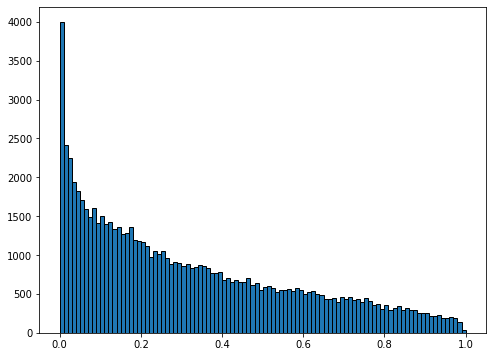

In [10]:
plt.figure(figsize=(8,6))
bins= np.linspace(0,1,101)
ax = plt.gca()
ax.hist(af, bins=bins,ec="k")
plt.show()

### Test HDF5 Allele Frequencies

In [30]:
ch = 3
h5_target = f"/n/groups/reich/hringbauer/hapsburg_runs/data/data_eirini/h5/all_ch{ch}.h5"

f= h5py.File(h5_target, "r")
#print(np.shape(f["calldata/GT"]))
af1 = f["variants/AF_ALL"][:]  
f.close()